In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-10-17 16:52:35.937752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 16:52:35.937901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [6]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.zeros(x_shift.shape)
# # the original mo, e.g. homo
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)

# homo_ = np.zeros(homo.shape)
# lumo_ = np.zeros(lumo.shape)

# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_[:,0] = np.add(homo[:,0],0)
#         homo_[:,1] = np.add(homo[:,1],i)
#         homo_[:,2] = np.add(homo[:,2],j)
#         homo_[:,3] = np.add(homo[:,3],3.5)
        
#         homo_pair_ = md.MO_pair_descriptor(homo, homo_).make()
#         homo_pairs[idx] = homo_pair_
        
#         lumo_[:,0] = np.add(lumo[:,0],0)
#         lumo_[:,1] = np.add(lumo[:,1],i)
#         lumo_[:,2] = np.add(lumo[:,2],j)
#         lumo_[:,3] = np.add(lumo[:,3],3.5)
        
#         lumo_pair_ = md.MO_pair_descriptor(lumo, lumo_).make()
#         lumo_pairs[idx] = lumo_pair_
        
# def dir_mat(mat):
#     mat_shape = mat.shape
#     mat_ = mat.flatten()
#     for ii, i in enumerate(mat_):
#         if i > 1e-6:
#             mat_[ii] = 1
#         elif (i < 1e-6) and (i > -1e-6):
#             mat_[ii] = -1
#         elif i < -1e-6:
#             mat_[ii] = -1
#     return mat_.reshape(mat_shape)

# direct = dir_mat(homo_pair)

# # for the shifted pair
# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)
# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_pairs[idx][0] = homo_pair[0]
#         homo_pairs[idx][1] = np.add(homo_pair[1],i*direct[1])
#         homo_pairs[idx][2] = np.add(homo_pair[2],j*direct[2])
#         homo_pairs[idx][3] = homo_pair[3]
#         lumo_pairs[idx][0] = lumo_pair[0]
#         lumo_pairs[idx][1] = np.add(lumo_pair[1],i)
#         lumo_pairs[idx][2] = np.add(lumo_pair[2],j)
#         lumo_pairs[idx][3] = lumo_pair[3]
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('homo_homo_pair.npy')
lumo_pairs = np.load('lumo_lumo_pair.npy')

1 start clustering
2 start getting center


/home/dgg95223/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


1 start clustering
2 start getting center


/home/dgg95223/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


[[[ 1.17720025e+01  1.17725309e+01  1.17736781e+01  1.17729480e+01
   -1.17726308e+01 -1.17719033e+01 -1.17730482e+01 -1.17735768e+01]
  [ 1.17725309e+01  1.17730594e+01  1.17742067e+01  1.17734765e+01
   -1.17731593e+01 -1.17724318e+01 -1.17735768e+01 -1.17741053e+01]
  [ 1.17736781e+01  1.17742067e+01  1.17753540e+01  1.17746238e+01
   -1.17743066e+01 -1.17735789e+01 -1.17747241e+01 -1.17752526e+01]
  [ 1.17729480e+01  1.17734765e+01  1.17746238e+01  1.17738936e+01
   -1.17735764e+01 -1.17728488e+01 -1.17739938e+01 -1.17745224e+01]
  [-1.17726308e+01 -1.17731593e+01 -1.17743066e+01 -1.17735764e+01
    1.17732593e+01  1.17725317e+01  1.17736767e+01  1.17742052e+01]
  [-1.17719033e+01 -1.17724318e+01 -1.17735789e+01 -1.17728488e+01
    1.17725317e+01  1.17718041e+01  1.17729490e+01  1.17734776e+01]
  [-1.17730482e+01 -1.17735768e+01 -1.17747241e+01 -1.17739938e+01
    1.17736767e+01  1.17729490e+01  1.17740941e+01  1.17746227e+01]
  [-1.17735768e+01 -1.17741053e+01 -1.17752526e+01 -1.1

In [17]:
'''
2. read coupling
'''
raw_data = np.loadtxt('../ML_Coupling/results.csv', delimiter=',',comments='#')
# c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
# c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2
c_homo = raw_data[:,3]
c_lumo = raw_data[:,4]

In [18]:
# x1 = homo_pairs[:,0,:,:]
# x2 = homo_pairs[:,1,:,:]
# x3 = homo_pairs[:,2,:,:]
# x4 = homo_pairs[:,3,:,:]
# x = np.einsum('aij,aij,aij,aij->aij', x1, x2, x3, x4)

train_homo_pairs = homo_pairs
train_lumo_pairs = lumo_pairs

train_c_homo = -np.log(c_homo)
train_c_lumo = -np.log(c_lumo)

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

/home/dgg95223/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/dgg95223/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [9]:
setting = {'activation':'tanh', 'nn_shape':(256,256,256), 'batch_size':1681, 'training_steps':200000,\
'learning_rate': 0.000001, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./save',\
'seed':None, 'debug_traj': False}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_pairs,train_c_homo)

2022-10-17 17:00:04.673708: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-17 17:00:04.673856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Deng-PC): /proc/driver/nvidia/version does not exist
2022-10-17 17:00:04.675207: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


loss:  10.7663488
training step:     0
loss:  7.5243187
training step:  1000
loss:  7.33554792
training step:  2000
loss:  7.19674635
training step:  3000
loss:  7.06537199
training step:  4000
loss:  6.93724251
training step:  5000
loss:  6.80838299
training step:  6000
loss:  6.67772198
training step:  7000
loss:  6.54480553
training step:  8000
loss:  6.41181469
training step:  9000
loss:  6.2788825
training step: 10000
loss:  6.1457324
training step: 11000
loss:  6.01249313
training step: 12000
loss:  5.87871647
training step: 13000
loss:  5.74449
training step: 14000
loss:  5.6099062
training step: 15000
loss:  5.47520638
training step: 16000
loss:  5.34037638
training step: 17000
loss:  5.20544291
training step: 18000
loss:  5.0704093
training step: 19000
loss:  4.93540573
training step: 20000
loss:  4.8004694
training step: 21000
loss:  4.66557837
training step: 22000
loss:  4.53075171
training step: 23000
loss:  4.3959918
training step: 24000
loss:  4.26133966
training step: 25

2022-10-17 18:13:48.985905: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./save/model/assets


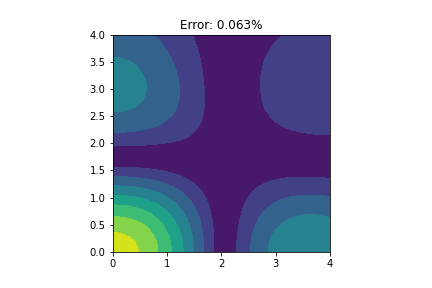

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

error = np.mean(np.multiply(NN.model(train_homo_pairs, training=False).numpy().reshape((1681,))-train_c_homo, np.power(train_c_homo,-1))*100)
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
X, Y = np.meshgrid(x, y)
Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41)).T
Z1 = c_homo.reshape((41,41)).T

fix, ax = plt.subplots()
ax.contourf(x,y, np.exp(-Z))
ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')
# plt.savefig('homo_pred.png')

In [ ]:
NN.model.summary()

In [ ]:
a = NN.model(train_homo_pairs, training=False).numpy().reshape((1681,))

In [ ]:
print(a.shape)

In [ ]:
print(np.mean(np.multiply(a-train_c_homo, np.power(train_c_homo,-1)))*100)

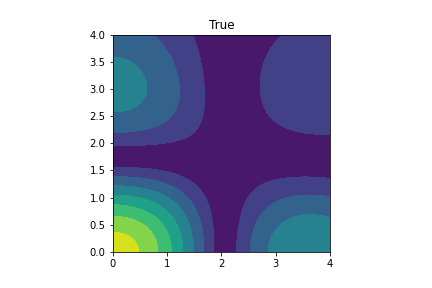

In [19]:
fix, ax = plt.subplots()
ax.contourf(x,y, Z1)
ax.set_title('True')
ax.set_aspect('equal')
# plt.savefig('homo_true.png')